In [133]:
from copy import deepcopy
from typing import List, Dict
import numpy as np
import matplotlib.pyplot as plt
import cirq
import openfermion as of
from openfermionpyscf import run_pyscf
from kcommute import commutes

## Sampling the perturbation with improtance sampling

_Goal:_ Sample the summation of the Trotter perturbation using importance sampling.
$\epsilon_2 = \bra{\phi} \hat{V}_2 \ket{\phi},$

where

$\hat{V}_2 = \frac{-1}{24} \sum_{\mu=1}^{2M-1} \sum_{\nu=\mu+1}^{2M} \sum_{\nu'=\nu}^{2M} 
\bigg( 1 - \frac{\delta_{\nu,\nu'}}{2}\bigg) [H_{\nu'}, [H_{\nu}, H_{\mu}]]$

We want to use a helper distribution where a term is more likely if $[H_\nu, H_\mu] \neq 0$.

_Hypothesis:_ Non-diagonal terms anti-commute more frequently.

## Commutation map for Hubbard

In [103]:
l = 2
t = 1.0
u = 4.0

ham = of.fermi_hubbard(l, l, t, u, spinless=True)
ham_jw = of.transforms.jordan_wigner(ham)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
blocks = [qs] # Used for commutation check.
nq = len(qs)
print(f"Hamiltonian has {nq} qubits.")

Hamiltonian has 17 terms.
Hamiltonian has 4 qubits.


Sort the terms so that all non-diagonal strings come first, then all the diagonal strings after them. Make a map of which strings commute.

In [104]:
def pstring_is_diagonal(pstring: cirq.PauliString) -> bool:
    """Test if a Pauli string is diagonal."""

    is_diagonal = True
    for q, p in pstring.items():
        if p == cirq.X or p == cirq.Y:
            is_diagonal = False
            break
    return is_diagonal

In [105]:
# Sort terms between diagonal and non-diagonal.
diagonal_terms: List[cirq.PauliString] = []
non_diagonal_terms: List[cirq.PauliString] = []
for p in ham_cirq:
    if pstring_is_diagonal(p):
        diagonal_terms.append(p)
    else:
        non_diagonal_terms.append(p)
num_diagonal = len(diagonal_terms)
sorted_terms = diagonal_terms + non_diagonal_terms

commute_map = np.zeros((nterms, nterms), dtype=bool)
for i, p1 in enumerate(sorted_terms):
    for j, p2 in enumerate(sorted_terms):
        if commutes(p1, p2, blocks):
            commute_map[i, j] = True

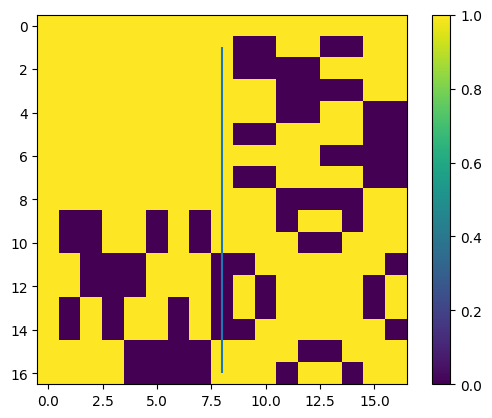

In [106]:
fig, ax = plt.subplots()
im = ax.imshow(commute_map)
ax.vlines(num_diagonal-1, 1, nterms-1)
fig.colorbar(im)

In [107]:
diag_diag_block = commute_map[:num_diagonal, :num_diagonal]
diag_non_diag_block = commute_map[:num_diagonal, num_diagonal:]
non_diag_non_diag_block = commute_map[num_diagonal:, num_diagonal:]
print(f"Diagnal-diagonal: {np.sum(diag_diag_block.astype(int))}/{np.size(diag_diag_block)} = {np.sum(diag_diag_block.astype(int))/np.size(diag_diag_block)}")
print(f"Diagnal-non-diagonal: {np.sum(diag_non_diag_block.astype(int))}/{np.size(diag_non_diag_block)} = {np.sum(diag_non_diag_block.astype(int))/np.size(diag_non_diag_block)}")
print(f"Non-diagnal-non-diagonal: {np.sum(non_diag_non_diag_block.astype(int))}/{np.size(non_diag_non_diag_block)} = {np.sum(non_diag_non_diag_block.astype(int))/np.size(non_diag_non_diag_block)}")

Diagnal-diagonal: 81/81 = 1.0
Diagnal-non-diagonal: 40/72 = 0.5555555555555556
Non-diagnal-non-diagonal: 48/64 = 0.75


## Commutation map for H chain

In [108]:
natoms = 4
bond_length = 1.0 
geometry = [("H", (0, 0, i * bond_length)) for i in range(natoms)]
molecule = of.MolecularData(geometry, basis="sto-3g", multiplicity=1, charge=0)
molecule = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)  # To get ground state energy for comparison etc., also can use DMRG
fermion_hamiltonian = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_jw = of.jordan_wigner(fermion_hamiltonian)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
blocks = [qs]
nq = len(qs)

Hamiltonian has 185 terms.


In [109]:
# Sort terms between diagonal and non-diagonal.
diagonal_terms: List[cirq.PauliString] = []
non_diagonal_terms: List[cirq.PauliString] = []
for p in ham_cirq:
    if pstring_is_diagonal(p):
        diagonal_terms.append(p)
    else:
        non_diagonal_terms.append(p)
num_diagonal = len(diagonal_terms)
sorted_terms = diagonal_terms + non_diagonal_terms

commute_map = np.zeros((nterms, nterms), dtype=bool)
for i, p1 in enumerate(sorted_terms):
    for j, p2 in enumerate(sorted_terms):
        if commutes(p1, p2, blocks):
            commute_map[i, j] = True

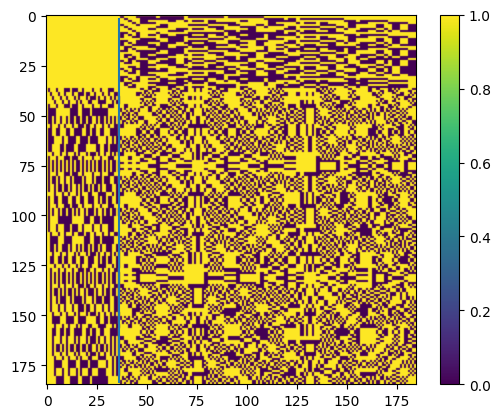

In [110]:
fig, ax = plt.subplots()
im = ax.imshow(commute_map)
ax.vlines(num_diagonal-1, 1, nterms-1)
fig.colorbar(im)

In [111]:
diag_diag_block = commute_map[:num_diagonal, :num_diagonal]
diag_non_diag_block = commute_map[:num_diagonal, num_diagonal:]
non_diag_non_diag_block = commute_map[num_diagonal:, num_diagonal:]
print(f"Diagnal-diagonal: {np.sum(diag_diag_block.astype(int))}/{np.size(diag_diag_block)} = {np.sum(diag_diag_block.astype(int))/np.size(diag_diag_block)}")
print(f"Diagnal-non-diagonal: {np.sum(diag_non_diag_block.astype(int))}/{np.size(diag_non_diag_block)} = {np.sum(diag_non_diag_block.astype(int))/np.size(diag_non_diag_block)}")
print(f"Non-diagnal-non-diagonal: {np.sum(non_diag_non_diag_block.astype(int))}/{np.size(non_diag_non_diag_block)} = {np.sum(non_diag_non_diag_block.astype(int))/np.size(non_diag_non_diag_block)}")

Diagnal-diagonal: 1369/1369 = 1.0
Diagnal-non-diagonal: 2852/5476 = 0.5208181154127101
Non-diagnal-non-diagonal: 12720/21904 = 0.5807158509861212


## Commutation map for LiH

In [112]:
molec = "LiH"
basis = "sto-3g"
n_elec = 4
geometry = of.chem.geometry_from_pubchem(molec)
multiplicity = 1
dmrg_max_bond = [14, 15, 16]
tebd_max_bond = deepcopy(dmrg_max_bond)
mpo_max_bond = 500
steps = 10
eps = 1e-12
d = 15

In [113]:
# Get the Hamiltonian.
molecule = of.chem.MolecularData(
    geometry, basis, multiplicity
)
molecule = run_pyscf(molecule, run_scf=1, run_fci=1)
print(f"HF energy:", molecule.hf_energy)
print(f"FCI energy:", molecule.fci_energy)
hamiltonian = molecule.get_molecular_hamiltonian()
hamiltonian_qubop = of.transforms.jordan_wigner(hamiltonian)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(hamiltonian_qubop)
nterms = len(ham_cirq)
print(f"Hamiltonian has {nterms} terms.")
qs = ham_cirq.qubits
blocks = [qs]

HF energy: -7.767362135748557
FCI energy: -7.784460280031223
Hamiltonian has 631 terms.


In [114]:
# Sort terms between diagonal and non-diagonal.
diagonal_terms: List[cirq.PauliString] = []
non_diagonal_terms: List[cirq.PauliString] = []
for p in ham_cirq:
    if pstring_is_diagonal(p):
        diagonal_terms.append(p)
    else:
        non_diagonal_terms.append(p)
num_diagonal = len(diagonal_terms)
sorted_terms = diagonal_terms + non_diagonal_terms

commute_map = np.zeros((nterms, nterms), dtype=bool)
for i, p1 in enumerate(sorted_terms):
    for j, p2 in enumerate(sorted_terms):
        if commutes(p1, p2, blocks):
            commute_map[i, j] = True

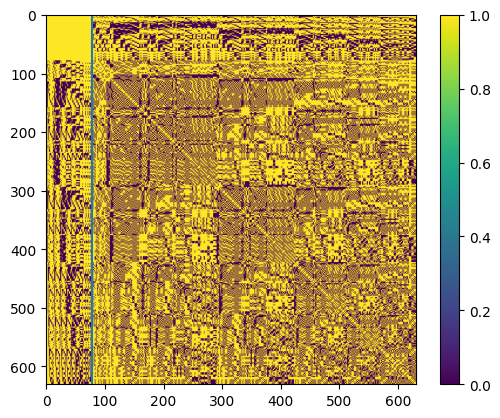

In [115]:
fig, ax = plt.subplots()
im = ax.imshow(commute_map)
ax.vlines(num_diagonal-1, 1, nterms-1)
fig.colorbar(im)

In [116]:
diag_diag_block = commute_map[:num_diagonal, :num_diagonal]
diag_non_diag_block = commute_map[:num_diagonal, num_diagonal:]
non_diag_non_diag_block = commute_map[num_diagonal:, num_diagonal:]
print(f"Diagnal-diagonal: {np.sum(diag_diag_block.astype(int))}/{np.size(diag_diag_block)} = {np.sum(diag_diag_block.astype(int))/np.size(diag_diag_block)}")
print(f"Diagnal-non-diagonal: {np.sum(diag_non_diag_block.astype(int))}/{np.size(diag_non_diag_block)} = {np.sum(diag_non_diag_block.astype(int))/np.size(diag_non_diag_block)}")
print(f"Non-diagnal-non-diagonal: {np.sum(non_diag_non_diag_block.astype(int))}/{np.size(non_diag_non_diag_block)} = {np.sum(non_diag_non_diag_block.astype(int))/np.size(non_diag_non_diag_block)}")

Diagnal-diagonal: 6241/6241 = 1.0
Diagnal-non-diagonal: 27432/43608 = 0.6290588882773803
Non-diagnal-non-diagonal: 184512/304704 = 0.6055450535601764


## Sorting by weight: Hubbard

In [126]:
l = 3
t = 1.0
u = 4.0

ham = of.fermi_hubbard(l, l, t, u, spinless=True)
ham_jw = of.transforms.jordan_wigner(ham)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
blocks = [qs] # Used for commutation check.
nq = len(qs)
print(f"Hamiltonian has {nq} qubits.")

Hamiltonian has 64 terms.
Hamiltonian has 9 qubits.


In [127]:
ham_terms = [ps for ps in ham_cirq]
sorted_terms = sorted(ham_terms, key=lambda ps: len(ps))

In [128]:
commute_map = np.zeros((nterms, nterms), dtype=bool)
for i, p1 in enumerate(sorted_terms):
    for j, p2 in enumerate(sorted_terms):
        if commutes(p1, p2, blocks):
            commute_map[i, j] = True

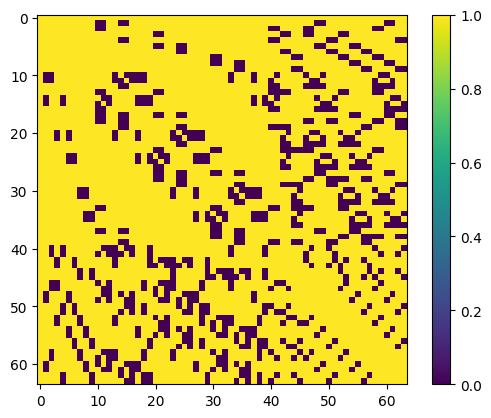

In [129]:
fig, ax = plt.subplots()
im = ax.imshow(commute_map)
fig.colorbar(im)

## Sorting by weight: LiH

In [130]:
molec = "LiH"
basis = "sto-3g"
n_elec = 4
geometry = of.chem.geometry_from_pubchem(molec)
multiplicity = 1
dmrg_max_bond = [14, 15, 16]
tebd_max_bond = deepcopy(dmrg_max_bond)
mpo_max_bond = 500
steps = 10
eps = 1e-12
d = 15

# Get the Hamiltonian.
molecule = of.chem.MolecularData(
    geometry, basis, multiplicity
)
molecule = run_pyscf(molecule, run_scf=1, run_fci=1)
print(f"HF energy:", molecule.hf_energy)
print(f"FCI energy:", molecule.fci_energy)
hamiltonian = molecule.get_molecular_hamiltonian()
hamiltonian_qubop = of.transforms.jordan_wigner(hamiltonian)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(hamiltonian_qubop)
nterms = len(ham_cirq)
print(f"Hamiltonian has {nterms} terms.")
qs = ham_cirq.qubits
blocks = [qs]

HF energy: -7.767362135748557
FCI energy: -7.784460280031223
Hamiltonian has 631 terms.


In [131]:
ham_terms = [ps for ps in ham_cirq]
sorted_terms = sorted(ham_terms, key=lambda ps: len(ps))

commute_map = np.zeros((nterms, nterms), dtype=bool)
for i, p1 in enumerate(sorted_terms):
    for j, p2 in enumerate(sorted_terms):
        if commutes(p1, p2, blocks):
            commute_map[i, j] = True

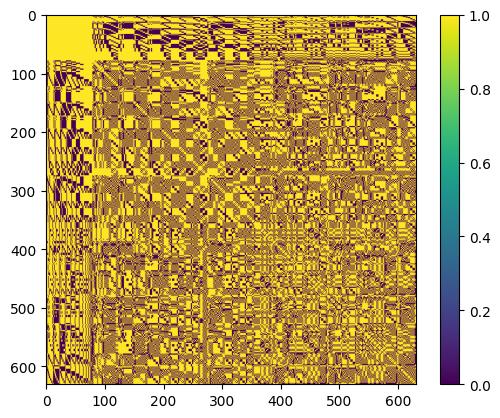

In [132]:
fig, ax = plt.subplots()
im = ax.imshow(commute_map)
fig.colorbar(im)

## Shared support size: Hubbard

Let $P_1$ have support $S_1$ and $P_2$ have support $S_2$. Does $|S_1 \cup S_2|$ predict how likely two terms are to commute?

In [149]:
l = 3
t = 1.0
u = 4.0

ham = of.fermi_hubbard(l, l, t, u, spinless=True)
ham_jw = of.transforms.jordan_wigner(ham)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
blocks = [qs] # Used for commutation check.
nq = len(qs)
print(f"Hamiltonian has {nq} qubits.")

Hamiltonian has 64 terms.
Hamiltonian has 9 qubits.


In [150]:
support_size_to_stats: Dict[int, Dict[str, int]] = {}
for p1 in ham_cirq:
    qs1 = set(p1.qubits)
    for p2 in ham_cirq:
        qs2 = set(p2.qubits)
        shared_suppport = qs1 & qs2
        shared_support_size = len(shared_suppport)
        if shared_support_size in support_size_to_stats.keys():
            support_size_to_stats[shared_support_size]["total"] += 1
            if commutes(p1, p2, blocks):
                support_size_to_stats[shared_support_size]["num_commuting"] += 1
        else:
            if commutes(p1, p2, blocks):
                support_size_to_stats[shared_support_size] = {"total": 1, "num_commuting": 1}
            else:
                support_size_to_stats[shared_support_size] = {"total": 1, "num_commuting": 0}

In [151]:
sizes = []
ratios = []
for size, inner_dict in support_size_to_stats.items():
    sizes.append(size)
    ratios.append(float(inner_dict["num_commuting"]) / float(inner_dict["total"]))

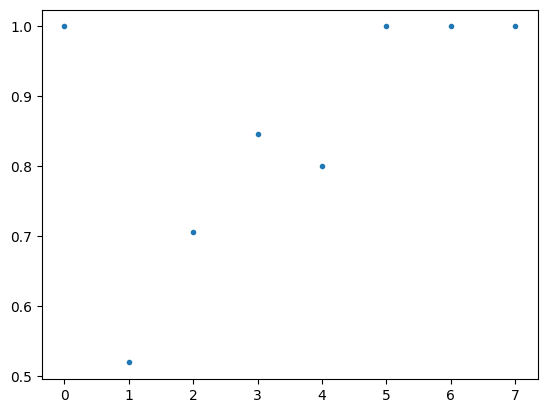

In [152]:
fig, ax = plt.subplots()
ax.plot(sizes, ratios, '.')

## Shared domain size: LiH

In [153]:
molec = "LiH"
basis = "sto-3g"
n_elec = 4
geometry = of.chem.geometry_from_pubchem(molec)
multiplicity = 1
dmrg_max_bond = [14, 15, 16]
tebd_max_bond = deepcopy(dmrg_max_bond)
mpo_max_bond = 500
steps = 10
eps = 1e-12
d = 15

# Get the Hamiltonian.
molecule = of.chem.MolecularData(
    geometry, basis, multiplicity
)
molecule = run_pyscf(molecule, run_scf=1, run_fci=1)
print(f"HF energy:", molecule.hf_energy)
print(f"FCI energy:", molecule.fci_energy)
hamiltonian = molecule.get_molecular_hamiltonian()
hamiltonian_qubop = of.transforms.jordan_wigner(hamiltonian)
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(hamiltonian_qubop)
nterms = len(ham_cirq)
print(f"Hamiltonian has {nterms} terms.")
qs = ham_cirq.qubits
blocks = [qs]

HF energy: -7.767362135748557
FCI energy: -7.784460280031223
Hamiltonian has 631 terms.


In [154]:
support_size_to_stats: Dict[int, Dict[str, int]] = {}
for p1 in ham_cirq:
    qs1 = set(p1.qubits)
    for p2 in ham_cirq:
        qs2 = set(p2.qubits)
        shared_suppport = qs1 & qs2
        shared_support_size = len(shared_suppport)
        if shared_support_size in support_size_to_stats.keys():
            support_size_to_stats[shared_support_size]["total"] += 1
            if commutes(p1, p2, blocks):
                support_size_to_stats[shared_support_size]["num_commuting"] += 1
        else:
            if commutes(p1, p2, blocks):
                support_size_to_stats[shared_support_size] = {"total": 1, "num_commuting": 1}
            else:
                support_size_to_stats[shared_support_size] = {"total": 1, "num_commuting": 0}

In [155]:
sizes = []
ratios = []
for size, inner_dict in support_size_to_stats.items():
    sizes.append(size)
    ratios.append(float(inner_dict["num_commuting"]) / float(inner_dict["total"]))

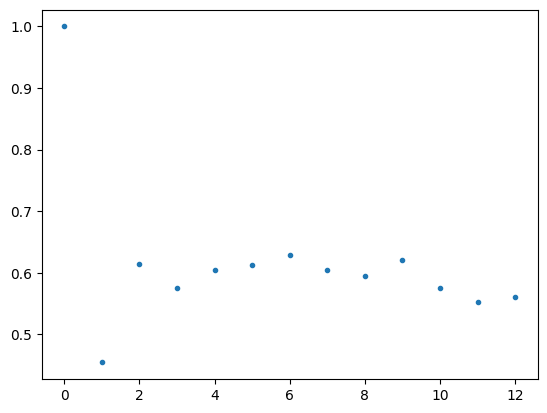

In [156]:
fig, ax = plt.subplots()
ax.plot(sizes, ratios, '.')

## Shared domain size: H chains

In [161]:
natoms = 6
bond_length = 1.0 
geometry = [("H", (0, 0, i * bond_length)) for i in range(natoms)]
molecule = of.MolecularData(geometry, basis="sto-3g", multiplicity=1, charge=0)
molecule = run_pyscf(molecule, run_mp2=True, run_cisd=True, run_ccsd=True, run_fci=True)  # To get ground state energy for comparison etc., also can use DMRG
fermion_hamiltonian = of.get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_jw = of.jordan_wigner(fermion_hamiltonian)
nterms = len(ham_jw.terms)
print(f"Hamiltonian has {nterms} terms.")
ham_cirq = of.transforms.qubit_operator_to_pauli_sum(ham_jw)
qs = ham_cirq.qubits
blocks = [qs]
nq = len(qs)

Hamiltonian has 919 terms.


In [162]:
support_size_to_stats: Dict[int, Dict[str, int]] = {}
for p1 in ham_cirq:
    qs1 = set(p1.qubits)
    for p2 in ham_cirq:
        qs2 = set(p2.qubits)
        shared_suppport = qs1 & qs2
        shared_support_size = len(shared_suppport)
        if shared_support_size in support_size_to_stats.keys():
            support_size_to_stats[shared_support_size]["total"] += 1
            if commutes(p1, p2, blocks):
                support_size_to_stats[shared_support_size]["num_commuting"] += 1
        else:
            if commutes(p1, p2, blocks):
                support_size_to_stats[shared_support_size] = {"total": 1, "num_commuting": 1}
            else:
                support_size_to_stats[shared_support_size] = {"total": 1, "num_commuting": 0}

In [163]:
sizes = []
ratios = []
for size, inner_dict in support_size_to_stats.items():
    sizes.append(size)
    ratios.append(float(inner_dict["num_commuting"]) / float(inner_dict["total"]))

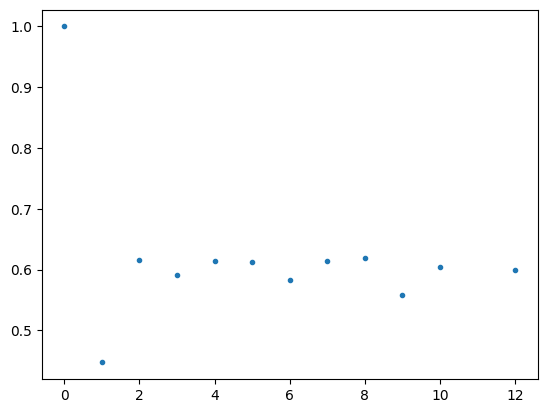

In [164]:
fig, ax = plt.subplots()
ax.plot(sizes, ratios, '.')